In [1]:
import sys
import os
from functools import reduce, partial
from copy import deepcopy

os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'

import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from numpyro.diagnostics import effective_sample_size
import dill
from scipy.stats import norm

import flax.linen as nn
import optax

/home/luke/anaconda3/envs/flax/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open("SEIAR_experiments/SEIAR_350_obs.pkl", "rb") as f:
    snl_350 = dill.load(f)

with open("SEIAR_experiments/SEIAR_500_obs.pkl", "rb") as f:
    snl_500 = dill.load(f)

with open("SEIAR_experiments/SEIAR_1000_obs.pkl", "rb") as f:
    snl_1000 = dill.load(f)

with open("SEIAR_experiments/SEIAR_2000_obs.pkl", "rb") as f:
    snl_2000 = dill.load(f)


with open("SEIAR_experiments/SEIAR_350_obs_dummy.pkl", "rb") as f:
    snl_dummy = dill.load(f)

In [3]:
pmmh350 = np.loadtxt("SEIAR_experiments/seiar350PMMHsamples.csv",delimiter=",", dtype=float)
pmmh350_1 = np.loadtxt("SEIAR_experiments/seiar350PMMHsamples1.csv",delimiter=",", dtype=float)
pmmh350 = np.concatenate((pmmh350, pmmh350_1), axis=0)

pmmh500 = np.loadtxt("SEIAR_experiments/seiar500PMMHsamples.csv",delimiter=",", dtype=float)
pmmh500_1 = np.loadtxt("SEIAR_experiments/seiar500PMMHsamples1.csv",delimiter=",", dtype=float)
pmmh500 = np.concatenate((pmmh500, pmmh500_1), axis=0)

pmmh1000 = np.loadtxt("SEIAR_experiments/seiar1000PMMHsamples.csv",delimiter=",", dtype=float)
pmmh1000_1 = np.loadtxt("SEIAR_experiments/seiar1000PMMHsamples1.csv",delimiter=",", dtype=float)
pmmh1000 = np.concatenate((pmmh1000, pmmh1000_1), axis=0)

pmmh2000 = np.loadtxt("SEIAR_experiments/seiar2000PMMHsamples.csv",delimiter=",", dtype=float)
pmmh2000_1 = np.loadtxt("SEIAR_experiments/seiar2000PMMHsamples1.csv",delimiter=",", dtype=float)
pmmh2000 = np.concatenate((pmmh2000, pmmh2000_1), axis=0)

In [4]:
def concat_samples(snl):
    R0_vals = np.concatenate(reduce(lambda x, y: x + [y['R0']], snl['samples'][-5:], []))
    gammai_vals = np.concatenate(reduce(lambda x, y: x + [y['gamma_inv']], snl['samples'][-5:], []))
    sigmai_vals = np.concatenate(reduce(lambda x, y: x + [y['sigma_inv']], snl['samples'][-5:], []))
    kappa_vals = np.concatenate(reduce(lambda x, y: x + [y['kappa']], snl['samples'][-5:], []))
    q_vals = np.concatenate(reduce(lambda x, y: x + [y['q']], snl['samples'][-5:], []))
    return R0_vals, gammai_vals, sigmai_vals, kappa_vals, q_vals

In [5]:
R0_350, gammai_350, sigmai_350, kappa_350, q_350 = concat_samples(snl_350)
R0_500, gammai_500, sigmai_500, kappa_500, q_500 = concat_samples(snl_500)
R0_1000, gammai_1000, sigmai_1000, kappa_1000, q_1000 = concat_samples(snl_1000)
R0_2000, gammai_2000, sigmai_2000, kappa_2000, q_2000 = concat_samples(snl_2000)

R0_d, gammai_d, sigmai_d, kappa_d, q_d = concat_samples(snl_dummy)

In [6]:
_, idx350 = np.unique(pmmh350[:, 0], return_index=True)
_, idx500 = np.unique(pmmh500[:, 0], return_index=True)
_, idx1000 = np.unique(pmmh1000[:, 0], return_index=True)
_, idx2000 = np.unique(pmmh2000[:, 0], return_index=True)

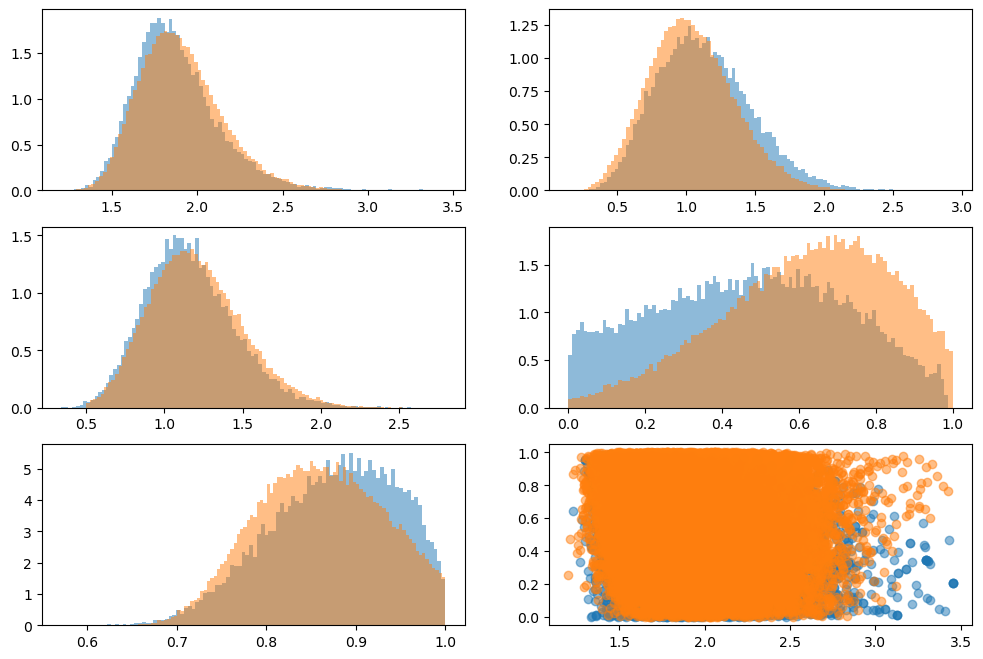

In [7]:
fig, ax = plt.subplots(3,2, figsize=(12,8))
ax[0,0].hist(R0_d, bins=100, density=True, alpha=0.5)
ax[0,0].hist(pmmh350[idx350, 0], bins=100, density=True, alpha=0.5)

ax[0,1].hist(sigmai_d, bins=100, density=True, alpha=0.5)
ax[0,1].hist(pmmh350[idx350, 1], bins=100, density=True, alpha=0.5)

ax[1,0].hist(gammai_d, bins=100, density=True, alpha=0.5)
ax[1,0].hist(pmmh350[idx350, 2], bins=100, density=True, alpha=0.5)

ax[1,1].hist(kappa_d, bins=100, density=True, alpha=0.5)
ax[1,1].hist(pmmh350[idx350, 3], bins=100, density=True, alpha=0.5)

ax[2,0].hist(q_d, bins=100, density=True, alpha=0.5)
ax[2,0].hist(pmmh350[idx350, 4], bins=100, density=True, alpha=0.5)

ax[2,1].scatter(R0_d, kappa_d, alpha=0.5)
ax[2,1].scatter(pmmh350[idx350, 0], pmmh350[idx350,3], alpha=0.5)
plt.show()

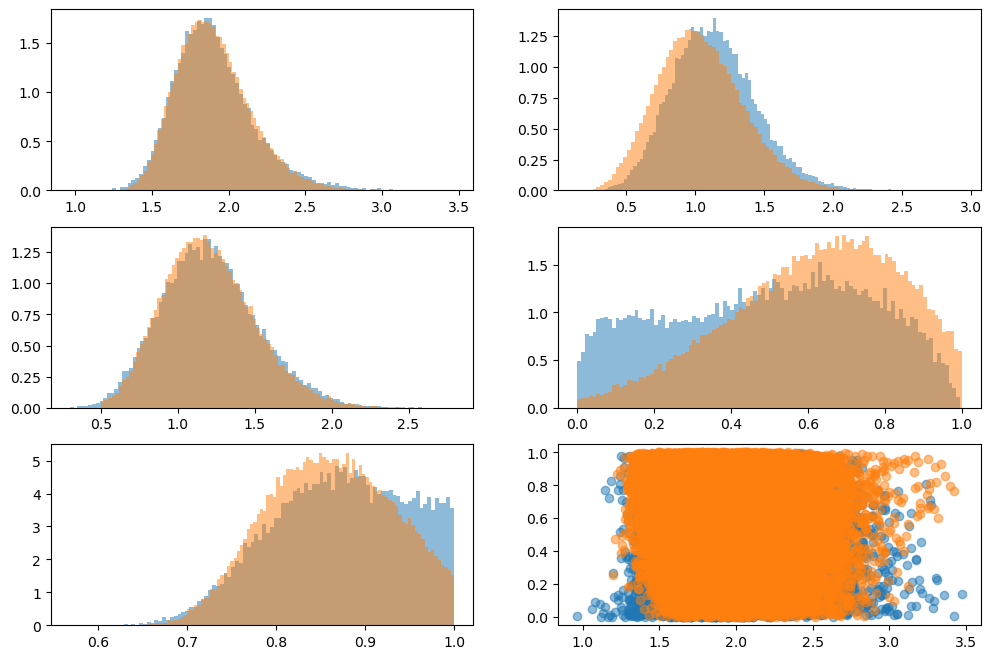

In [7]:
fig, ax = plt.subplots(3,2, figsize=(12,8))
ax[0,0].hist(R0_350, bins=100, density=True, alpha=0.5)
ax[0,0].hist(pmmh350[idx350, 0], bins=100, density=True, alpha=0.5)

ax[0,1].hist(sigmai_350, bins=100, density=True, alpha=0.5)
ax[0,1].hist(pmmh350[idx350, 1], bins=100, density=True, alpha=0.5)

ax[1,0].hist(gammai_350, bins=100, density=True, alpha=0.5)
ax[1,0].hist(pmmh350[idx350, 2], bins=100, density=True, alpha=0.5)

ax[1,1].hist(kappa_350, bins=100, density=True, alpha=0.5)
ax[1,1].hist(pmmh350[idx350, 3], bins=100, density=True, alpha=0.5)

ax[2,0].hist(q_350, bins=100, density=True, alpha=0.5)
ax[2,0].hist(pmmh350[idx350, 4], bins=100, density=True, alpha=0.5)

ax[2,1].scatter(R0_350, kappa_350, alpha=0.5)
ax[2,1].scatter(pmmh350[idx350, 0], pmmh350[idx350,3], alpha=0.5)
plt.show()

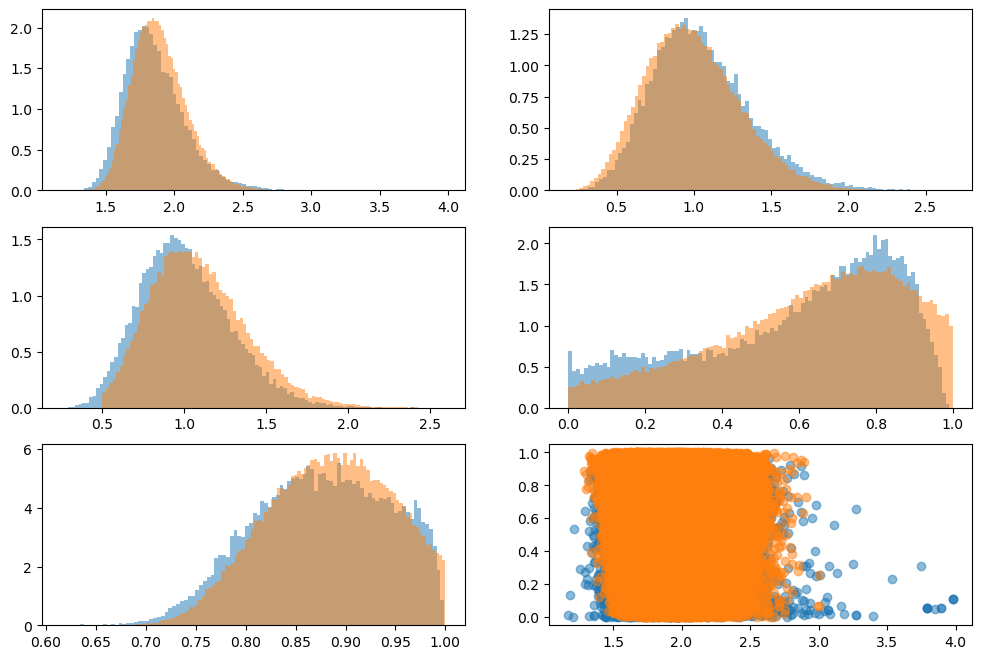

In [8]:
fig, ax = plt.subplots(3,2, figsize=(12,8))
ax[0,0].hist(R0_500, bins=100, density=True, alpha=0.5)
ax[0,0].hist(pmmh500[idx500, 0], bins=100, density=True, alpha=0.5)

ax[0,1].hist(sigmai_500, bins=100, density=True, alpha=0.5)
ax[0,1].hist(pmmh500[idx500, 1], bins=100, density=True, alpha=0.5)

ax[1,0].hist(gammai_500, bins=100, density=True, alpha=0.5)
ax[1,0].hist(pmmh500[idx500, 2], bins=100, density=True, alpha=0.5)

ax[1,1].hist(kappa_500, bins=100, density=True, alpha=0.5)
ax[1,1].hist(pmmh500[idx500, 3], bins=100, density=True, alpha=0.5)

ax[2,0].hist(q_500, bins=100, density=True, alpha=0.5)
ax[2,0].hist(pmmh500[idx500, 4], bins=100, density=True, alpha=0.5)

ax[2,1].scatter(R0_500, kappa_500, alpha=0.5)
ax[2,1].scatter(pmmh500[idx500, 0], pmmh500[idx500,3], alpha=0.5)
plt.show()

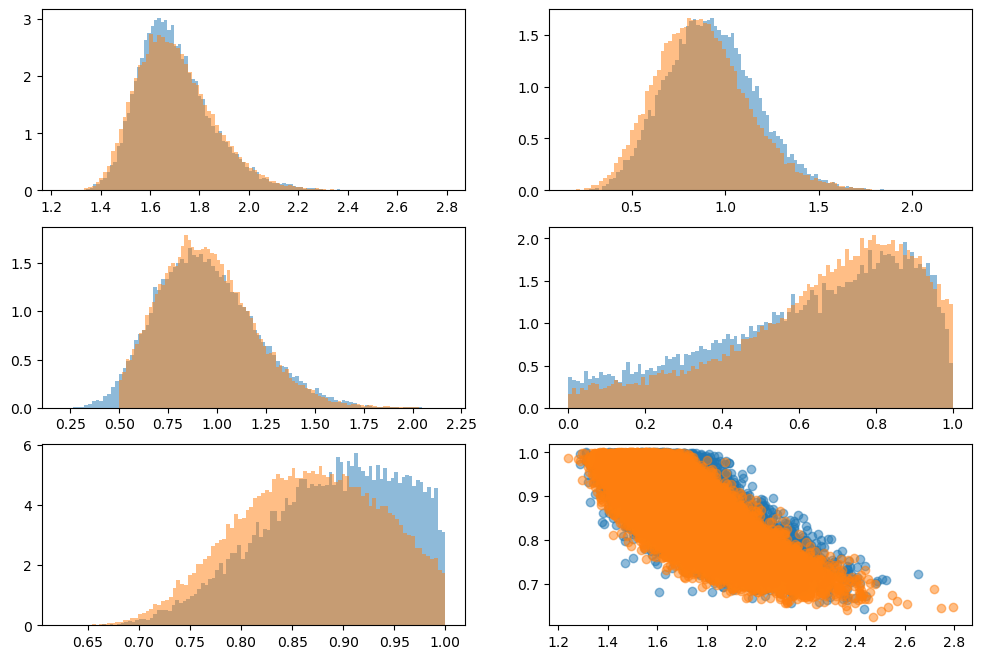

In [10]:
fig, ax = plt.subplots(3,2, figsize=(12,8))
ax[0,0].hist(R0_1000, bins=100, density=True, alpha=0.5)
ax[0,0].hist(pmmh1000[idx1000, 0], bins=100, density=True, alpha=0.5)

ax[0,1].hist(sigmai_1000, bins=100, density=True, alpha=0.5)
ax[0,1].hist(pmmh1000[idx1000, 1], bins=100, density=True, alpha=0.5)

ax[1,0].hist(gammai_1000, bins=100, density=True, alpha=0.5)
ax[1,0].hist(pmmh1000[idx1000, 2], bins=100, density=True, alpha=0.5)

ax[1,1].hist(kappa_1000, bins=100, density=True, alpha=0.5)
ax[1,1].hist(pmmh1000[idx1000, 3], bins=100, density=True, alpha=0.5)

ax[2,0].hist(q_1000, bins=100, density=True, alpha=0.5)
ax[2,0].hist(pmmh1000[idx1000, 4], bins=100, density=True, alpha=0.5)

ax[2,1].scatter(R0_1000, q_1000, alpha=0.5)
ax[2,1].scatter(pmmh1000[idx1000, 0], pmmh1000[idx1000,4], alpha=0.5)
plt.show()

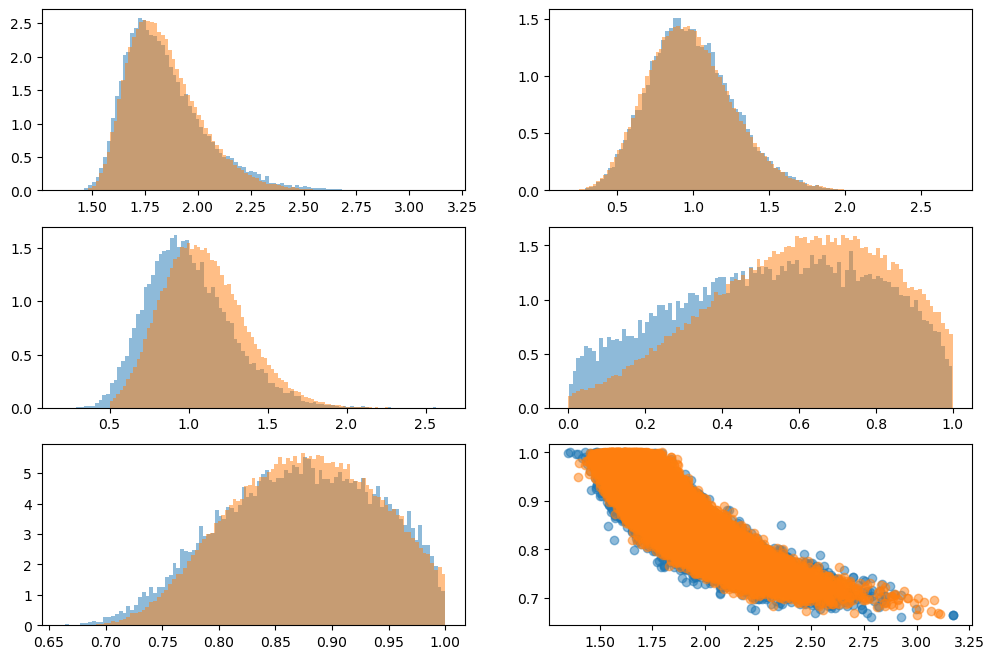

In [11]:
fig, ax = plt.subplots(3,2, figsize=(12,8))
ax[0,0].hist(R0_2000, bins=100, density=True, alpha=0.5)
ax[0,0].hist(pmmh2000[idx2000, 0], bins=100, density=True, alpha=0.5)

ax[0,1].hist(sigmai_2000, bins=100, density=True, alpha=0.5)
ax[0,1].hist(pmmh2000[idx2000, 1], bins=100, density=True, alpha=0.5)

ax[1,0].hist(gammai_2000, bins=100, density=True, alpha=0.5)
ax[1,0].hist(pmmh2000[idx2000, 2], bins=100, density=True, alpha=0.5)

ax[1,1].hist(kappa_2000, bins=100, density=True, alpha=0.5)
ax[1,1].hist(pmmh2000[idx2000, 3], bins=100, density=True, alpha=0.5)

ax[2,0].hist(q_2000, bins=100, density=True, alpha=0.5)
ax[2,0].hist(pmmh2000[idx2000, 4], bins=100, density=True, alpha=0.5)

ax[2,1].scatter(R0_2000, q_2000, alpha=0.5)
ax[2,1].scatter(pmmh2000[idx2000, 0], pmmh2000[idx2000,4], alpha=0.5)
plt.show()

In [12]:
class MLP(nn.Module):

    @nn.compact
    def __call__(self, x):
        x = nn.relu(nn.Dense(50)(x))
        return nn.Dense(1)(x)

In [13]:
model = MLP()

def create_params(key):
    # Define MLP model
    dummy_input = jnp.ones((5,))
    # Initialize parameters using dummy input
    params = model.init(key, dummy_input)
    return params

@jax.jit
def loss(params, x_batched, y_batched):
  # Define the squared loss for a single pair (x,y)
  def ce(x, y):
    z = model.apply(params, x)
    lsz = nn.log_sigmoid(z)
    return -y * lsz - (1 - y) * (lsz - z)
  # Vectorize the previous to compute the average of the loss on all samples.
  return jnp.mean(jax.vmap(ce)(x_batched,y_batched))

In [14]:
def make_dataset(snl, pmmh, num_test=10_000, val_prop=0.1, thin_pmmh_by=3):
    R0, gammai, sigmai, kappa, q = concat_samples(snl)
    xsnl = np.stack((R0, sigmai, gammai, kappa, q)).T
    ysnl = np.zeros(xsnl.shape[0])

    xpmmh = pmmh[::thin_pmmh_by]
    ypmmh = np.ones(xpmmh.shape[0])

    x = np.concatenate((xsnl, xpmmh), axis=0)
    y = np.concatenate((ysnl, ypmmh), axis=0)

    x = (x - x.mean(axis=0)) / x.std(axis=0)

    perm = np.random.permutation(x.shape[0])
    num_train = int((perm.shape[0] - num_test) * (1 - val_prop))
    num_val = perm.shape[0] - (num_test + num_train)
    train_idx, val_idx, test_idx = perm[:num_train], perm[num_train:(num_train+num_val)], perm[(num_train+num_val):]
    train_x, val_x, test_x = x[train_idx], x[val_idx], x[test_idx]
    train_y, val_y, test_y = y[train_idx], y[val_idx], y[test_idx]
    return {"train": (train_x, train_y), "val": (val_x, val_y), "test": (test_x, test_y)}

In [15]:
tx = optax.adam(learning_rate=1e-3)
loss_grad_fn = jax.value_and_grad(loss)

In [16]:
def make_epoch(tx, batch_size, loss_grad_fn):
    def body_fn(carry, batch):
        params, opt_state, train_x, train_y = carry
        _, grads = loss_grad_fn(params, train_x[batch, :], train_y[batch])
        updates, opt_state = tx.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return (params, opt_state, train_x, train_y), None
    
    @jax.jit
    def epoch(key, params, train_x, train_y, opt_state):
        perm = jax.random.permutation(key, train_x.shape[0])
        nsplit = perm.shape[0] // batch_size
        N = batch_size*nsplit
        batches = jnp.vstack(jnp.array_split(perm[:N], nsplit))
        (params, opt_state, _, _,), _ = jax.lax.scan(body_fn, (params, opt_state, train_x, train_y), xs=batches)
        (params, opt_state, _, _), _ = body_fn((params, opt_state, train_x, train_y), perm[N:])
        return params, opt_state

    return epoch

@jax.jit
def validate(params, val_x, val_y):
    return loss(params, val_x, val_y)


In [17]:
def train(key, train_ds, val_ds, tx, loss_grad_fn, batch_size, num_epochs):
    key, key1 = jax.random.split(key)
    params = create_params(key1)
    opt_state = tx.init(params)

    train_x, val_x = jnp.asarray(train_ds[0]), jnp.asarray(val_ds[0])
    train_y, val_y = jnp.asarray(train_ds[1]), jnp.asarray(val_ds[1])

    epoch = make_epoch(tx, batch_size, loss_grad_fn)
    validation_loss = np.zeros(num_epochs)
    best_val_loss = np.inf
    best_params = deepcopy(params)

    for i in range(num_epochs):
        key, key1 = jax.random.split(key)
        params, opt_state = epoch(key1, params, train_x, train_y, opt_state)
        val_loss = validate(params, val_x, val_y)
        validation_loss[i] = val_loss

        if validation_loss[i] < best_val_loss:
            best_val_loss = validation_loss[i]
            best_params = deepcopy(params)

    
    return best_params, opt_state, validation_loss
    

In [23]:
def train_ensemble(key, snl, pmmh, num_test=10_000, val_prop=0.1, batch_size=2048, num_epochs=100, thin_by=3):
    classifier_scores = []
    val_losses = []
    for _ in range(10):
        key, key1 = jax.random.split(key)
        ds = make_dataset(snl, pmmh, num_test=num_test, val_prop=val_prop, thin_pmmh_by=thin_by)
        params, _, validation_loss = train(key1, ds['train'], ds['val'], tx, loss_grad_fn, batch_size, num_epochs)

        prob_y = nn.sigmoid(model.apply(params, ds['test'][0]))
        pred_y = np.where(prob_y > 0.5, 1.0, 0.0)
        score = (pred_y == ds['test'][1]).mean()

        classifier_scores.append(score)
        val_losses.append(validation_loss)
    return classifier_scores, val_losses

In [29]:
idx2000.shape[0] // 4

30288

In [30]:
key = jax.random.PRNGKey(np.random.randint(0, 1_000_000_000))
key1, key = jax.random.split(key)
batch_size = 2048
num_epochs = 200
scores350, losses350 = train_ensemble(key1, snl_350, pmmh350[idx350, :], num_test=5_000, batch_size=batch_size, num_epochs=num_epochs)

In [35]:
key1, key = jax.random.split(key)
scores500, losses500 = train_ensemble(key1, snl_500, pmmh350[idx500, :], num_test=5_000, batch_size=batch_size, num_epochs=num_epochs)

In [37]:
key1, key = jax.random.split(key)
scores1000, losses1000 = train_ensemble(key1, snl_1000, pmmh1000[idx1000, :], num_test=5_000, batch_size=batch_size, num_epochs=num_epochs, thin_by=2)

In [41]:
key1, key = jax.random.split(key)
scores2000, losses2000 = train_ensemble(key1, snl_2000, pmmh2000[idx2000, :], num_test=5_000, batch_size=batch_size, num_epochs=num_epochs, thin_by=4)

In [43]:
scores2000

[0.5127328,
 0.51167712,
 0.51228512,
 0.51301856,
 0.5122176,
 0.51437576,
 0.5095844,
 0.51452752,
 0.51628664,
 0.510106]

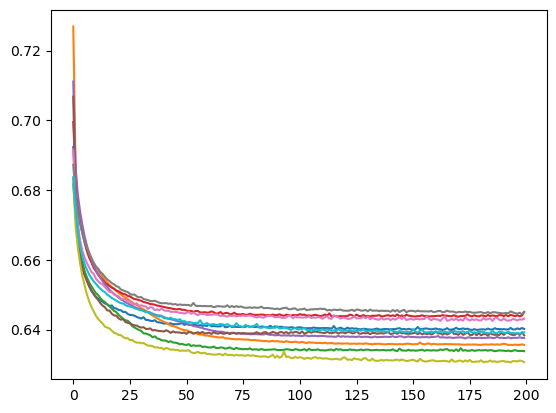

In [42]:
plt.plot(np.stack(losses2000).T)
plt.show()

In [47]:
print(f"N=350, {np.array(scores350).mean()}")
print(f"N=500, {np.array(scores500).mean()}")
print(f"N=1000, {np.array(scores1000).mean()}")
print(f"N=2000, {np.array(scores2000).mean()}")

N=350, 0.4995844720000001
N=500, 0.503072608
N=1000, 0.497474584
N=2000, 0.5126811520000001


In [50]:
Z350 = (np.array(scores350) - 0.5) * 2 * np.sqrt(5000)
Z500 = (np.array(scores500) - 0.5) * 2 * np.sqrt(5000)
Z1000 = (np.array(scores1000) - 0.5) * 2 * np.sqrt(5000)
Z2000 = (np.array(scores2000) - 0.5) * 2 * np.sqrt(5000)

In [64]:
print(f"N=350   avg p-value: {np.mean(2*(1 - norm.cdf(np.abs(Z350))))}")
print(f"N=500   avg p-value: {np.mean(2*(1 - norm.cdf(np.abs(Z500))))}")
print(f"N=1000   avg p-value: {np.mean(2*(1 - norm.cdf(np.abs(Z1000))))}")
print(f"N=2000   avg p-value: {np.mean(2*(1 - norm.cdf(np.abs(Z2000))))}")

N=350   avg p-value: 0.9514413465355718
N=500   avg p-value: 0.6670469643020364
N=1000   avg p-value: 0.7234512478409203
N=2000   avg p-value: 0.08338178446667033
